<a href="https://colab.research.google.com/github/redom13/ML/blob/main/CNN_handwritten_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Loading Dataset

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),                  # cz NN only accepts tensors
    ])

trainset = torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transform)

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

# Data Exploration

In [4]:
trainloader.dataset.data.shape

torch.Size([60000, 28, 28])

`28X28` images of handwritten digits

In [5]:
trainloader.dataset.targets.shape

torch.Size([60000])

In [6]:
trainloader.dataset.targets[:5]

tensor([5, 0, 4, 1, 9])

## Utility Function for plotting images

In [7]:
def plot_digit(dataLoader,index):
  image = dataLoader.dataset.data[index]
  plt.imshow(image,cmap='gray')
  plt.xlabel(f"True Label: {dataLoader.dataset.targets[index].item()}")
  plt.show()

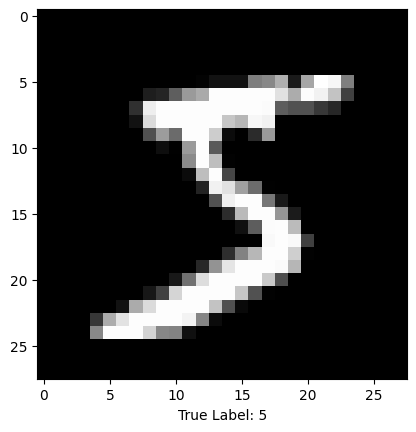

In [8]:
plot_digit(trainloader,0)

In [9]:
for x,y in trainloader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 1, 28, 28])
torch.Size([32])


- When we iterate over trainloader, it provides X_train,y_train batch by batch

# CNN

## CNN class

In [10]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # CNN layers
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=28,kernel_size=(3,3),stride=1,padding=1)
    self.act1 = nn.ReLU()
    self.drop1 = nn.Dropout(0.3)

    self.conv2 = nn.Conv2d(in_channels=28,out_channels=28,kernel_size=(3,3),stride=1,padding=1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

    # Flatten the 2D array
    self.flatten = nn.Flatten()
    # Dense Layers
    self.fc3 = nn.Linear(28*14*14,256)
    self.act3 = nn.ReLU()
    self.drop3 = nn.Dropout(0.4)

    self.fc4 = nn.Linear(256,10)

  def forward(self,x):
    # Input: 1x28x28, O/p: 28x28x28
    x = self.act1(self.conv1(x))
    x = self.drop1(x)
    # Input: 28x28x28, o/p: 28x28x28
    x = self.act2(self.conv2(x))
    # i/p: 28x28x28, o/p:28x14x14
    x = self.pool2(x)
    # i/p: 28x14x14, o/p:5488
    x = self.flatten(x)
    # i/p: 5488, o/p: 256
    x = self.act3(self.fc3(x))
    x = self.drop3(x)
    # i/p: 256, o/p: 10
    x = self.fc4(x)
    return x

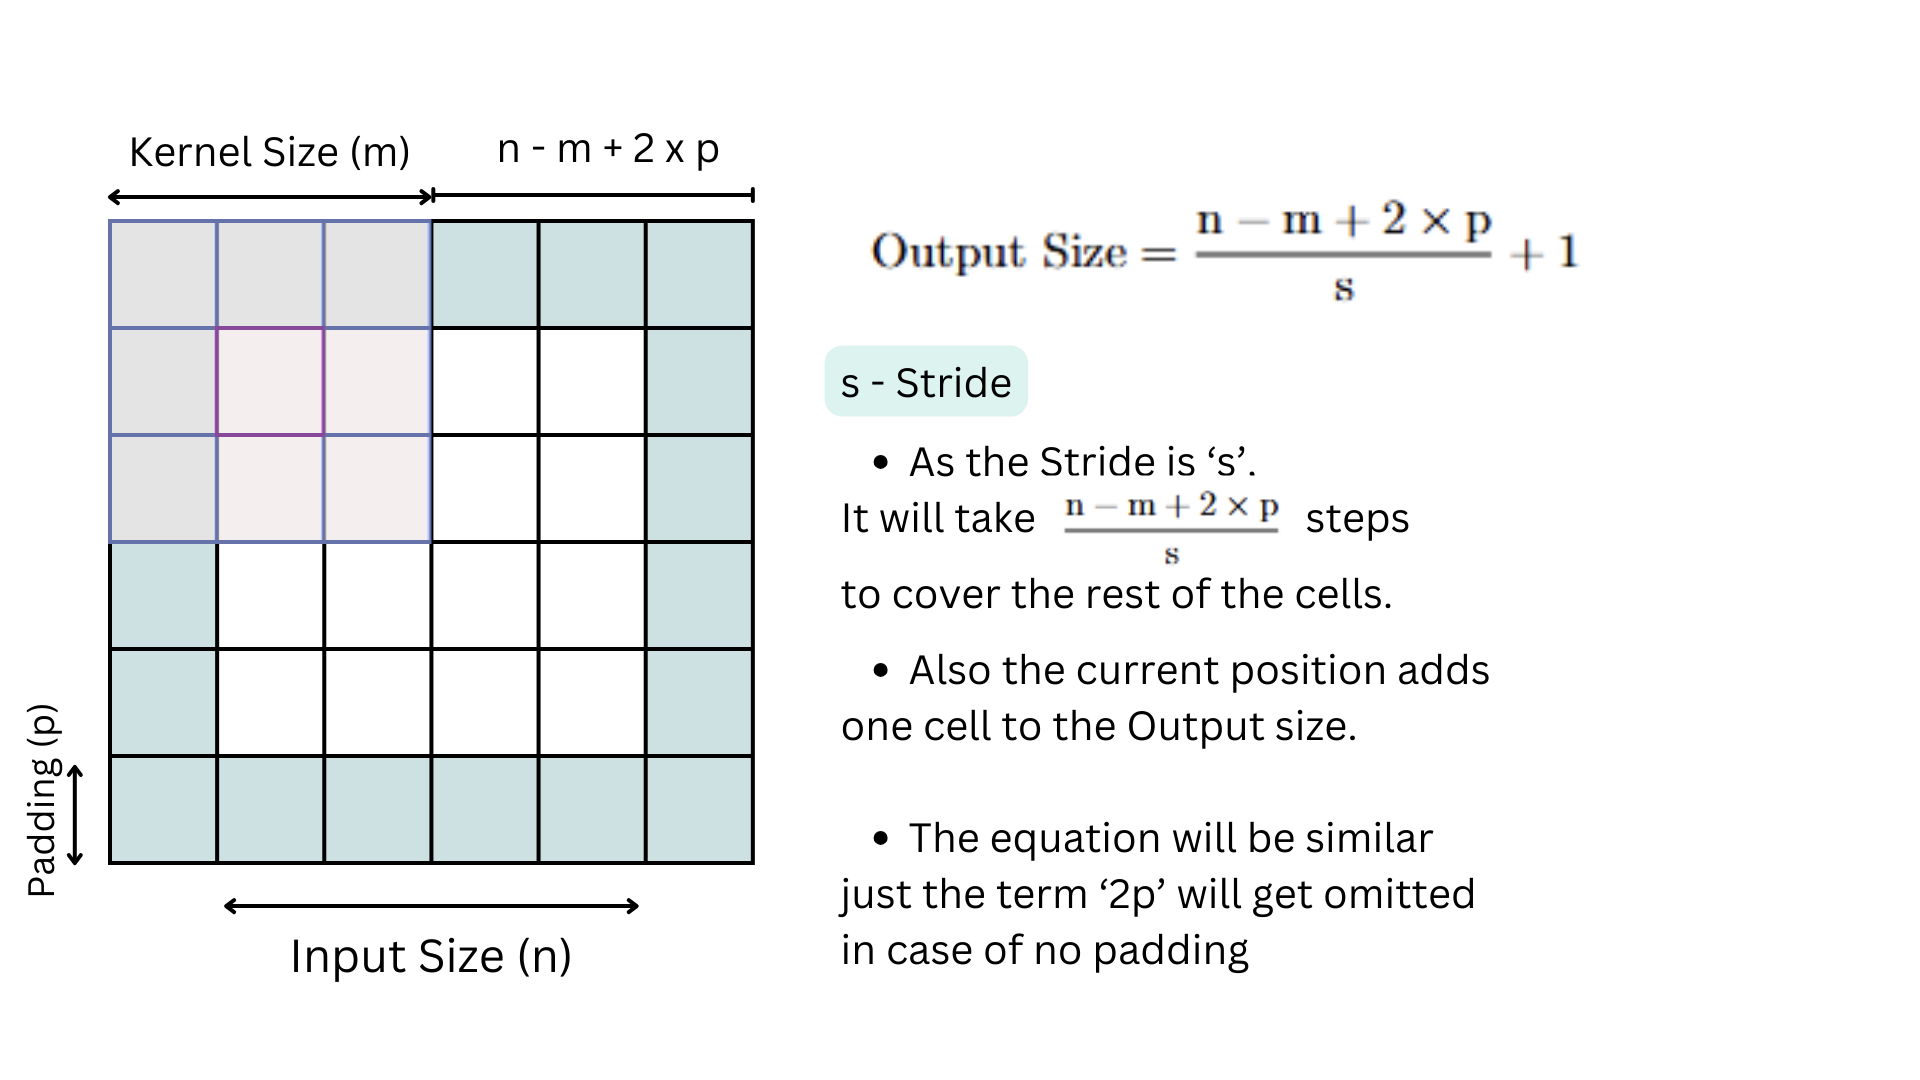

## Model Training and Evaluation

In [ ]:
!pip install torchmetrics

In [13]:
from tqdm.auto import tqdm # tqdm for Progress Bar
import torchmetrics

In [15]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

n_epochs = 10
for epoch in tqdm(range(n_epochs)):
  train_loss = 0
  for inputs,labels in trainloader:
    model.train()
    # Forward Propagation
    y_preds = model(inputs)
    # Loss calculation
    loss = loss_fn(y_preds,labels)
    train_loss += loss.item()
    # Resetting Gradient Descent to 0
    optimizer.zero_grad()
    # Back Propagation
    loss.backward()
    # Weight Update
    optimizer.step()

  train_loss /= len(trainloader)

  test_acc = 0
  test_loss = 0
  count = 0

  model.eval()

  with torch.inference_mode():
    for inputs,labels in testloader:
      y_preds = model(inputs)
      loss = loss_fn(y_preds,labels)
      test_loss += loss.item()
      test_acc += (torch.argmax(y_preds, 1) == labels).float().sum()
      # acc += torchmetrics.functional.accuracy(y_preds,labels)
      count += len(labels)

    test_loss /= len(testloader)
    test_acc /= count

  print(f"\nEpoch:{epoch+1} | Train Loss:{train_loss:.5f} | Test Loss:{test_loss:.5f} | Test Accuracy:{test_acc*100:.3}%\n")

torch.save(model.state_dict(),"CNN.pth")

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch:1 | Train Loss:0.19405 | Test Loss:0.04735 | Test Accuracy:98.4%


Epoch:2 | Train Loss:0.07015 | Test Loss:0.03762 | Test Accuracy:98.8%


Epoch:3 | Train Loss:0.05152 | Test Loss:0.03433 | Test Accuracy:99.0%


Epoch:4 | Train Loss:0.04159 | Test Loss:0.02686 | Test Accuracy:99.1%


Epoch:5 | Train Loss:0.03274 | Test Loss:0.02855 | Test Accuracy:99.2%


Epoch:6 | Train Loss:0.02808 | Test Loss:0.02914 | Test Accuracy:99.2%


Epoch:7 | Train Loss:0.02524 | Test Loss:0.03225 | Test Accuracy:99.0%


Epoch:8 | Train Loss:0.02239 | Test Loss:0.03145 | Test Accuracy:99.1%


Epoch:9 | Train Loss:0.01912 | Test Loss:0.02920 | Test Accuracy:99.2%


Epoch:10 | Train Loss:0.01686 | Test Loss:0.03267 | Test Accuracy:99.1%



## Prediction on Test Dataset

In [16]:
model.eval()

overall_preds = []
overall_labels = []

with torch.inference_mode():
  for inputs,labels in testloader:
    y_preds = model(inputs)
    overall_preds.append(torch.argmax(y_preds, 1))
    overall_labels.append(labels)

overall_preds = torch.cat(overall_preds)
overall_labels = torch.cat(overall_labels)

In [33]:
mismatched_indices = torch.where(overall_preds != overall_labels)[0]
len(mismatched_indices)

88

In [34]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

- Only 88 of 10000 predictions are Wrong

## Plotting the WRONG ones

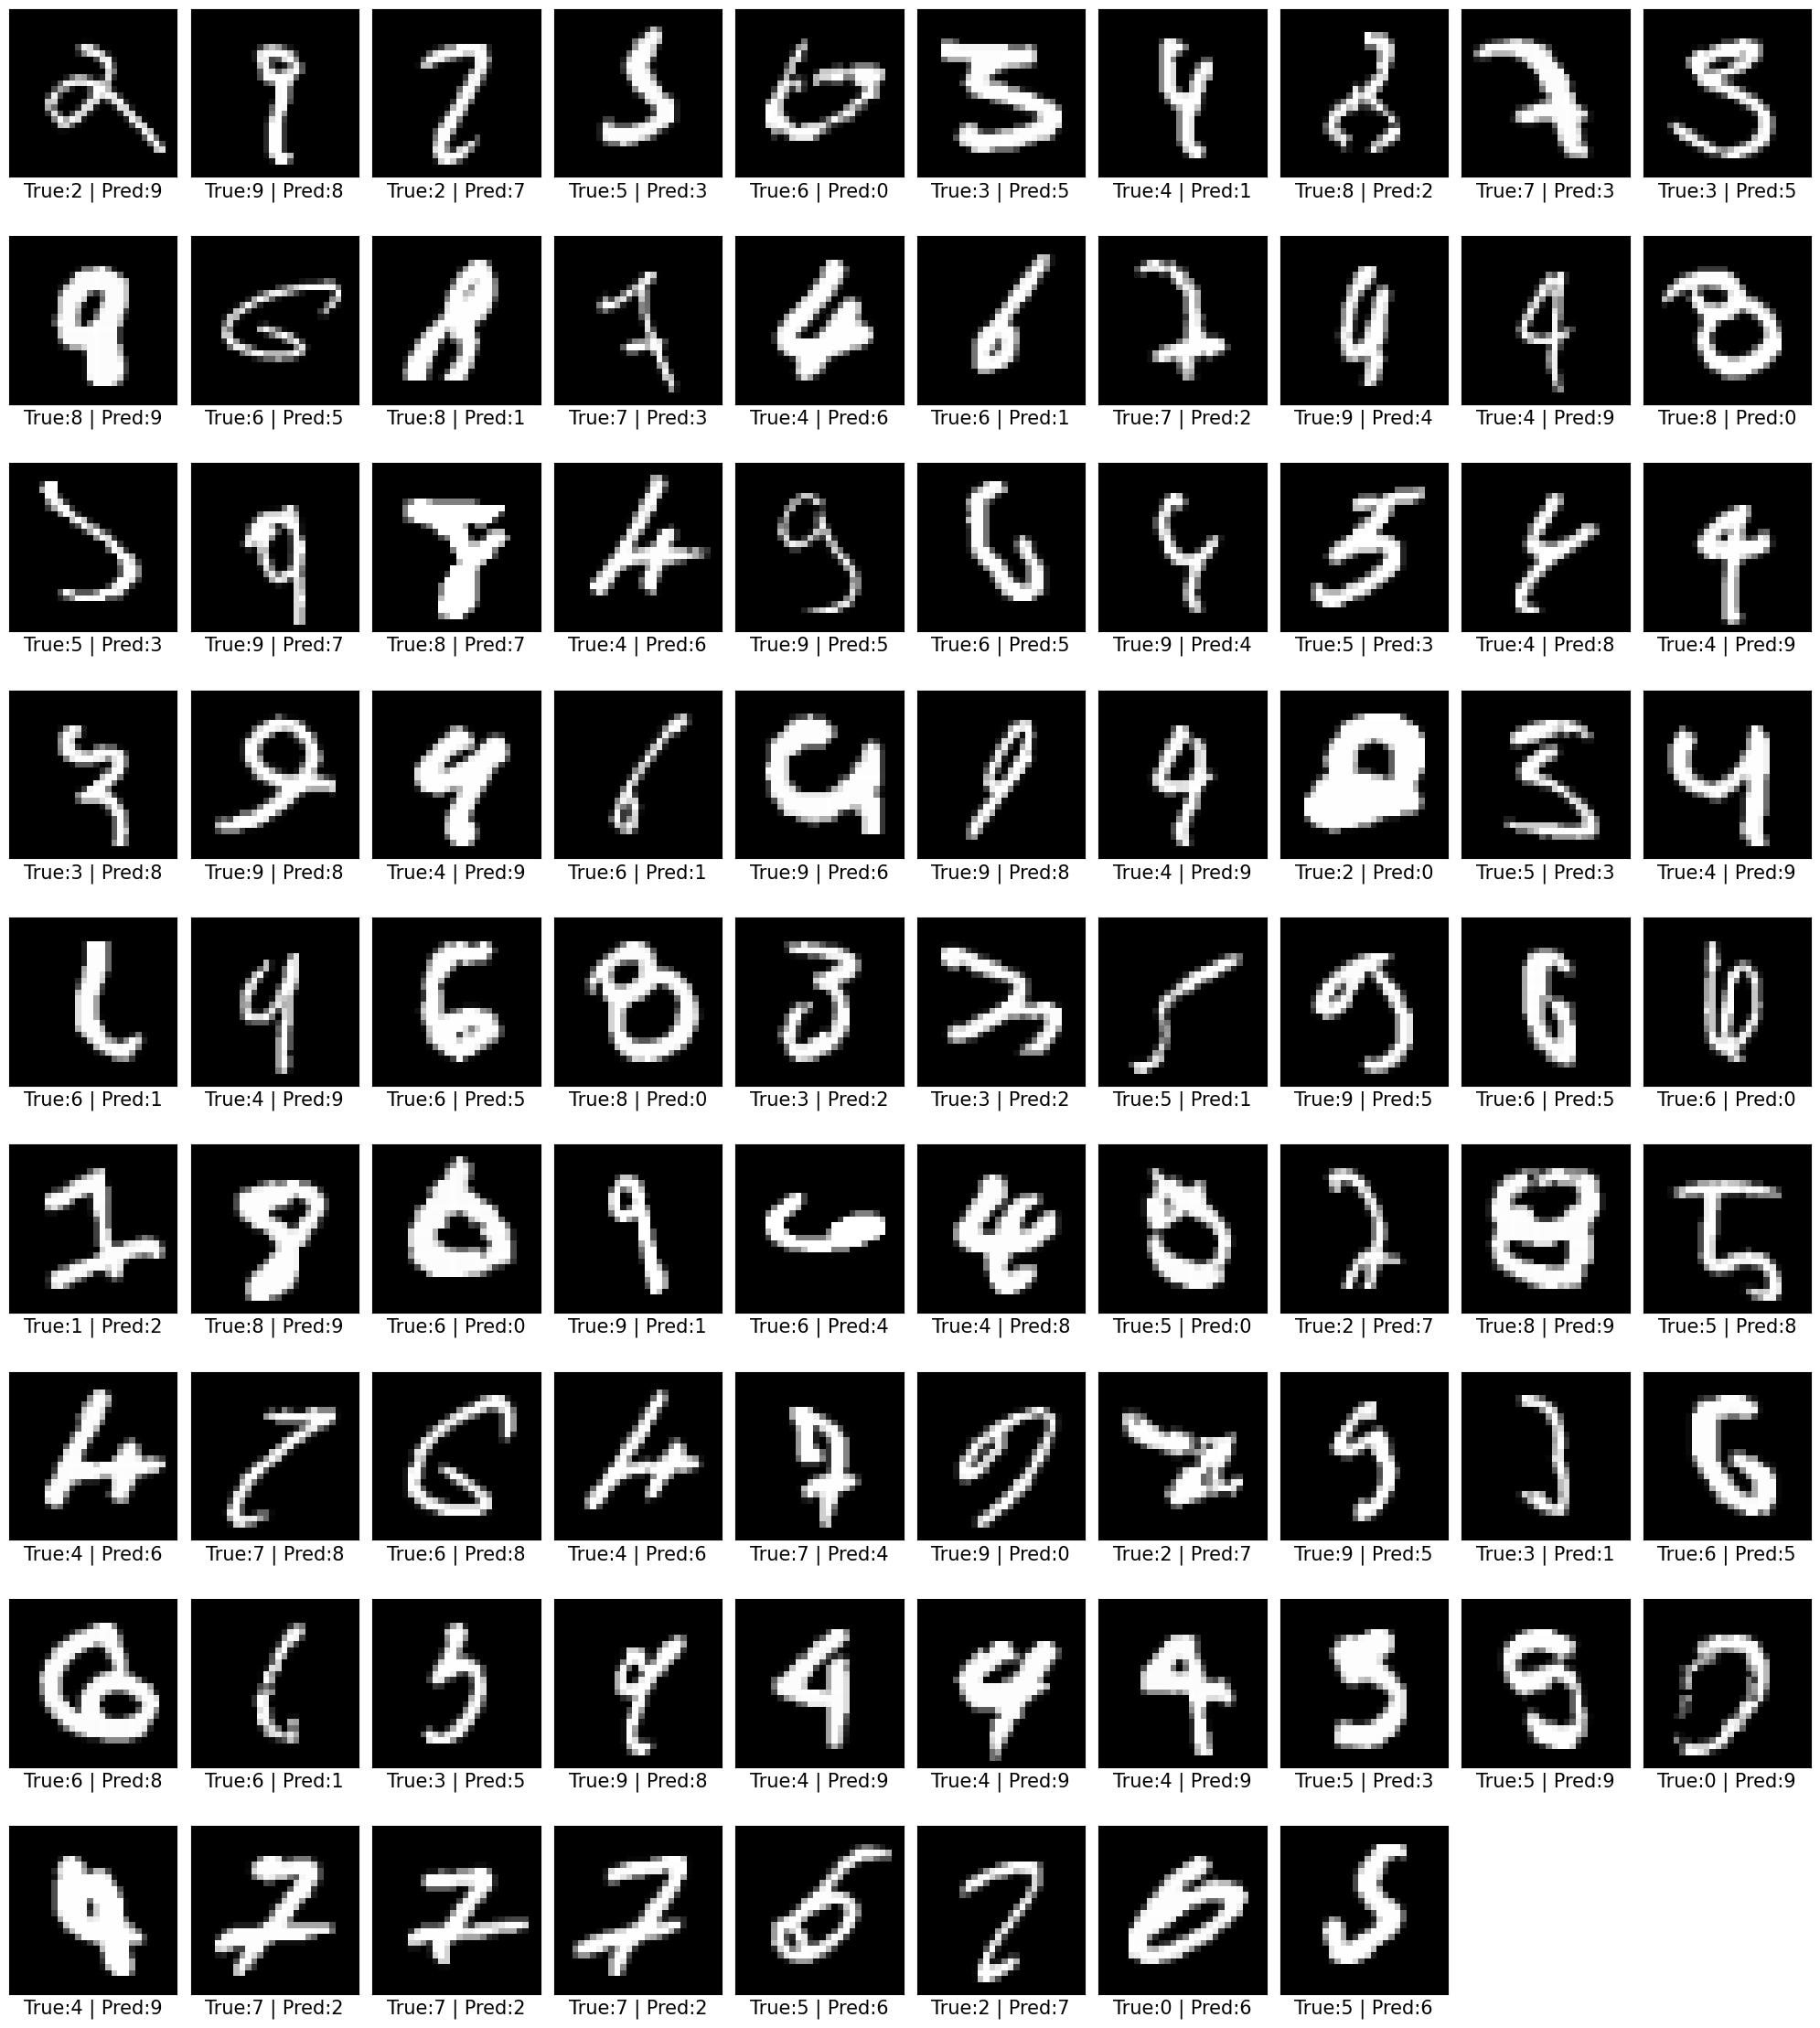

In [32]:
import math

cols = 10
rows = math.ceil(len(mismatched_indices) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 2.5 * rows))

for i, index in enumerate(mismatched_indices):
    row = i // cols
    col = i % cols
    predicted_label = overall_preds[index]
    image = testloader.dataset.data[index]
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_xlabel(
        f"True:{testloader.dataset.targets[index].item()} | Pred:{predicted_label}",
        fontsize=15,
        # rotation=45
    )
    # Keep the axis ticks hidden but allow labels
    axes[row, col].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Hide any unused subplots
for i in range(len(mismatched_indices), rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].axis('off')

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()
